In [2]:
import pandas as pd

# 🗂️ Chargement du fichier Parquet
chemin_fichier = "C:\\Users\\danie\\Desktop\\DamirDATA\\A202307.parquet"
df = pd.read_parquet(chemin_fichier)


# 🧹 Sélection des colonnes utiles
colonnes_utiles = [
    "AGE_BEN_SNDS",    # Âge
    "BEN_SEX_COD",     # Sexe
    "EXO_MTF",         # Exonération (à valider selon contexte)
    "PRS_NAT",         # Acte médical
    "PRS_REM_MNT",     # Montant remboursé (cible)
    "PSE_SPE_SNDS",    # Spécialité
    "BEN_RES_REG"      # Région de résidence
]

df = df[colonnes_utiles]
print("Colonnes sélectionnées :", df.columns.tolist())
print(df.head())

Colonnes sélectionnées : ['AGE_BEN_SNDS', 'BEN_SEX_COD', 'EXO_MTF', 'PRS_NAT', 'PRS_REM_MNT', 'PSE_SPE_SNDS', 'BEN_RES_REG']
   AGE_BEN_SNDS  BEN_SEX_COD  EXO_MTF  PRS_NAT  PRS_REM_MNT  PSE_SPE_SNDS  \
0            60            2       99     1951        -1.00             1   
1            60            1       99     3511        18.70             0   
2            70            2       99     1126         4.00            15   
3            80            2       99     1901         5.00             2   
4            60            1       99     3386         0.66             0   

   BEN_RES_REG  
0           32  
1           75  
2           75  
3           75  
4           44  


In [3]:
import numpy as np

# Remplacement des codes considérés comme "valeurs manquantes"
df.replace({
    "AGE_BEN_SNDS": {99: np.nan},
    "BEN_SEX_COD": {0: np.nan, 9: np.nan},
    "EXO_MTF": {99: np.nan},
    "PSE_SPE_SNDS": {0: np.nan, 99: np.nan},
    "BEN_RES_REG": {99: np.nan},
    "PRS_ACT_COG": {0: np.nan},  # Optionnel selon ton analyse
}, inplace=True)

# Vérification : taux de NaN maintenant visibles
print((df.isna().sum() / len(df) * 100).round(2).astype(str) + " %")

# Suppression des lignes incomplètes
df_clean = df.dropna()
print("Taille après suppression des lignes avec valeurs manquantes :", df_clean.shape)


AGE_BEN_SNDS     0.11 %
BEN_SEX_COD       0.0 %
EXO_MTF         41.17 %
PRS_NAT           0.0 %
PRS_REM_MNT       0.0 %
PSE_SPE_SNDS    74.76 %
BEN_RES_REG      6.15 %
dtype: object
Taille après suppression des lignes avec valeurs manquantes : (4242239, 7)


In [6]:
# 💸 Calcul de la moyenne des remboursements
moyenne_remboursement = df_clean["PRS_REM_MNT"].mean()
print(f"Moyenne des remboursements : {moyenne_remboursement:.2f} €")


Moyenne des remboursements : 387.48 €


In [ ]:
# 🎯 Nouveau critère : remboursement supérieur à la moyenne
df_clean.loc[:, "REMBOURSEMENT_ELEVE"] = (df_clean["PRS_REM_MNT"] > moyenne_remboursement).astype(int)

# 📊 Répartition des classes
print(df_clean["REMBOURSEMENT_ELEVE"].value_counts(normalize=True).round(3) * 100)

print("Classe 0 : remboursement ≤ moyenne | Classe 1 : remboursement > moyenne")



REMBOURSEMENT_ELEVE
0    89.2
1    10.8
Name: proportion, dtype: float64
Classe 0 : remboursement ≤ 387,48 € | Classe 1 : remboursement > 387,48 €


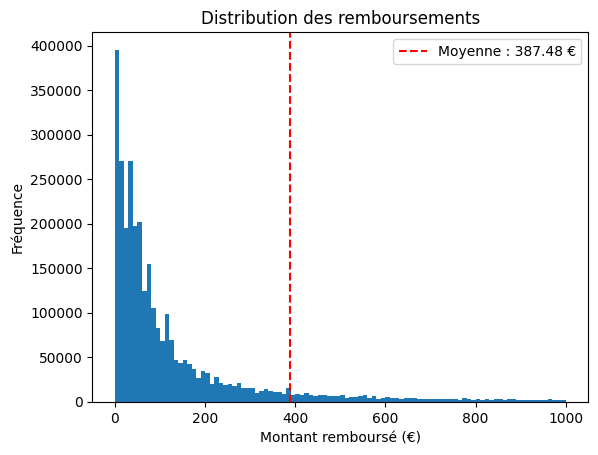

In [11]:
import matplotlib.pyplot as plt

plt.hist(df_clean["PRS_REM_MNT"], bins=100, range=(0, 1000))
plt.axvline(moyenne_remboursement, color='red', linestyle='--', label=f"Moyenne : {moyenne_remboursement:.2f} €")
plt.title("Distribution des remboursements")
plt.xlabel("Montant remboursé (€)")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

In [14]:
features = ["AGE_BEN_SNDS", "BEN_SEX_COD", "PRS_NAT", "BEN_RES_REG"]
X = df_clean[features]
y = df_clean["REMBOURSEMENT_ELEVE"]


In [17]:
from sklearn.preprocessing import LabelEncoder

X = X.copy()

# 📦 Création d’un encoder par variable catégorielle
encoders = {}
for col in ["BEN_SEX_COD", "PRS_NAT", "BEN_RES_REG"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le  # Pour réutiliser plus tard si besoin


In [18]:
from sklearn.model_selection import train_test_split

# 🧪 Split des données (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 📊 Vérif de la répartition des classes
print("Répartition des classes dans y_train :")
print(y_train.value_counts(normalize=True).round(3) * 100)

print("Répartition des classes dans y_test :")
print(y_test.value_counts(normalize=True).round(3) * 100)


Répartition des classes dans y_train :
REMBOURSEMENT_ELEVE
0    89.2
1    10.8
Name: proportion, dtype: float64
Répartition des classes dans y_test :
REMBOURSEMENT_ELEVE
0    89.2
1    10.8
Name: proportion, dtype: float64


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 🌲 Modèle Random Forest avec pondération automatique des classes
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

# 🚀 Entraînement
rf.fit(X_train, y_train)

# 🔮 Prédictions sur le test set
y_pred = rf.predict(X_test)

# 📊 Évaluation du modèle
print("🔎 Rapport de classification :")
print(classification_report(y_test, y_pred))

print("🧱 Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      0.57      0.72    756521
           1       0.19      0.86      0.32     91927

    accuracy                           0.60    848448
   macro avg       0.58      0.71      0.52    848448
weighted avg       0.89      0.60      0.67    848448

🧱 Matrice de confusion :
[[428582 327939]
 [ 12716  79211]]


🧠 Lecture des résultats :

✅ Classe 1 (remboursement > 387,48 € — la classe “minoritaire”) :
Recall : 0.86 → Tu détectes 86% des vrais remboursements élevés 💪
➤ Très bon pour ne pas rater les cas coûteux, ce qui est essentiel pour les décideurs !

Precision : 0.19 → Mais tu as beaucoup de faux positifs (tu dis que c’est élevé alors que ça ne l’est pas).

F1-score : 0.32 → Moyen, car c’est un compromis entre précision et recall.

❌ Classe 0 (remboursement ≤ 387,48 € — la majorité) :
Recall : 0.57 → Tu rates 43% des vrais petits remboursements 😅

Matrice de confusion :

Tu as 327 939 faux positifs → beaucoup de cas que tu sur-estimes.

⚖️ En résumé :
Ton modèle est très bon pour capter les cas coûteux (classe 1), ce qui est super pour ton objectif.

Mais il sacrifie la précision → ce n’est pas très fiable pour dire “ce patient va coûter cher”, car il crie souvent au loup 🐺

Globalement, accuracy = 60% : pas représentatif vu le déséquilibre.
➤ On préfère le recall classe 1 dans ton cas (prévention des gros remboursements = priorité !)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV-----------------------TRES LONG

# param_dist = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'class_weight': ['balanced']
# }

# random_search = RandomizedSearchCV(
#     RandomForestClassifier(random_state=42),
#     param_distributions=param_dist,
#     n_iter=10,
#     cv=3,
#     scoring='f1',
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)
# best_rf = random_search.best_estimator_


In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 📦 Modèle XGBoost avec gestion du déséquilibre (scale_pos_weight ≈ ratio classe 0 / classe 1)
# Comme tu as 89.2% de 0 et 10.8% de 1 → ratio ≈ 8.26
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=8.26,
    random_state=42
)

# 🚀 Entraînement
xgb.fit(X_train, y_train)

# 🔮 Prédiction
y_pred_xgb = xgb.predict(X_test)

# 📊 Évaluation
print("🔎 Rapport de classification (XGBoost) :")
print(classification_report(y_test, y_pred_xgb))

print("🧱 Matrice de confusion (XGBoost) :")
print(confusion_matrix(y_test, y_pred_xgb))


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [23:49:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔎 Rapport de classification (XGBoost) :
              precision    recall  f1-score   support

           0       0.97      0.56      0.71    756521
           1       0.19      0.87      0.32     91927

    accuracy                           0.59    848448
   macro avg       0.58      0.71      0.51    848448
weighted avg       0.89      0.59      0.67    848448

🧱 Matrice de confusion (XGBoost) :
[[422381 334140]
 [ 12021  79906]]


In [25]:
y_proba = xgb.predict_proba(X_test)[:, 1]  # Probabilité d'appartenir à classe 1
y_pred_custom = (y_proba > 0.8).astype(int)

print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.90      0.98      0.94    756521
           1       0.45      0.14      0.21     91927

    accuracy                           0.89    848448
   macro avg       0.68      0.56      0.58    848448
weighted avg       0.85      0.89      0.86    848448

[[740449  16072]
 [ 78931  12996]]


🧠 Interprétation :
Tu as renversé la tendance :

Avant, tu capturais presque tous les remboursements élevés (recall 0.87) mais tu avais énormément de faux positifs.

Maintenant, tu ne déclares "élevé" que si t’es très sûr → du coup :

Tu as moins de faux positifs

Mais tu rates beaucoup de vrais remboursements élevés (recall classe 1 très bas)

🎯 Ce que tu viens de démontrer :
💬 En jouant sur le seuil de décision, on peut prioriser la précision ou le rappel, selon l’objectif métier :

Objectif prévention / détection à tout prix → seuil bas → meilleur recall

Objectif fiabilité de l’alerte → seuil haut → meilleure précision

In [27]:
import shap

# 🧠 Initialisation de l'explainer pour XGBoost
explainer = shap.TreeExplainer(xgb)

# 💡 Calcul des valeurs SHAP sur un sous-échantillon pour gagner du temps
X_sample = X_test.sample(5000, random_state=42)
shap_values = explainer.shap_values(X_sample)


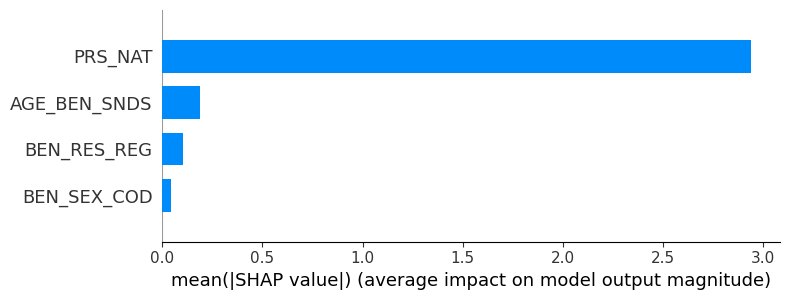

In [28]:
# 🔥 Vue globale : importance + impact des variables
shap.summary_plot(shap_values, X_sample, plot_type="bar")


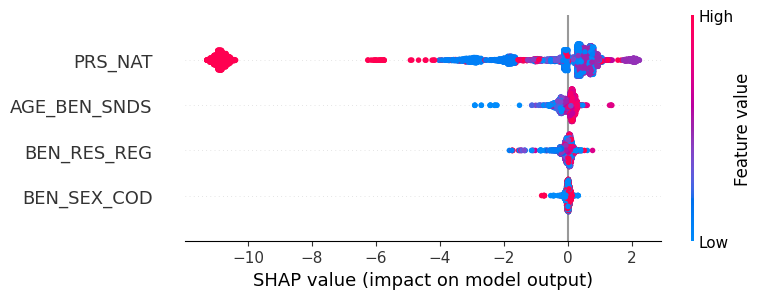

In [29]:
shap.summary_plot(shap_values, X_sample)


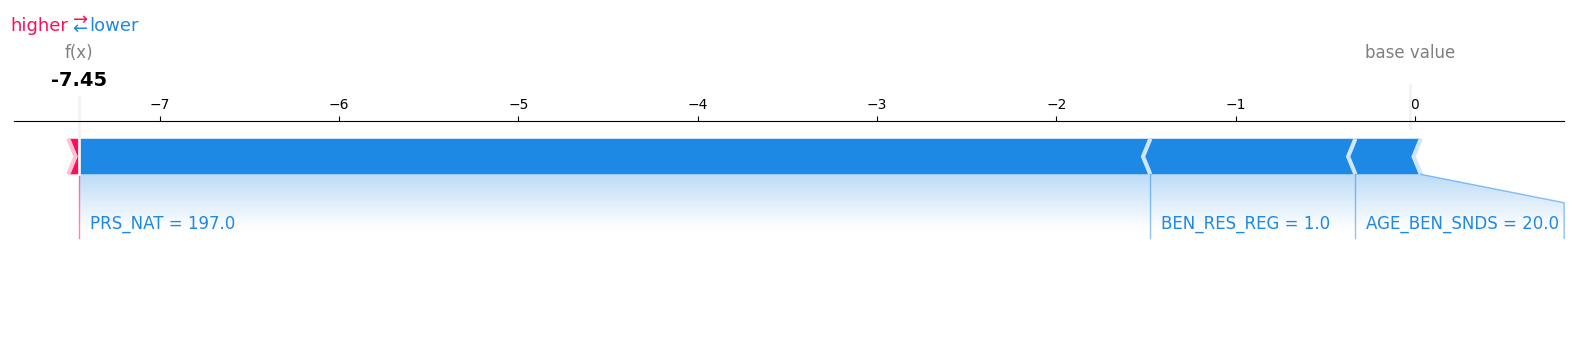

In [30]:
# Choisir un exemple
i = 0  # tu peux changer l’index ici
shap.force_plot(explainer.expected_value, shap_values[i], X_sample.iloc[i], matplotlib=True)


Et si on remboursait systématiquement les dépistages VIH chez les 18–25 ans ?

In [34]:
# 🔁 Duplication pour la version simulée
X_test_simul = X_test.copy()

# 🎯 Cibler les jeunes 18–25 ans
mask_jeunes = (X_test_simul["AGE_BEN_SNDS"] >= 18) & (X_test_simul["AGE_BEN_SNDS"] <= 25)

# 🔢 Encodage correct avec str()
code_vih = encoders["PRS_NAT"].transform([str(2206)])[0]


# 💊 Appliquer le changement pour les jeunes
X_test_simul.loc[mask_jeunes, "PRS_NAT"] = code_vih



ValueError: y contains previously unseen labels: [np.int64(2206)]